In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


In [71]:
# 1. read the ONS file
df = pd.read_excel("data/internetreferencetables.xlsx",
                   sheet_name="IntValSA", header=3)


In [72]:
df.head()

,Time Period,All retailing excluding automotive fuel [Note 1],Predominantly food stores,Total of predominantly non-food stores [Note 2],Non-specialised stores [Note 2],"Textile, clothing and footwear stores [Note 2]",Household goods stores [Note 2],Other stores [Note 2],Non-store retailing
0,Agg/SIC,Agg 21X,Agg 1,Agg 12,47.19,Agg 5,Agg 7,Agg 13,Agg 14
1,Dataset identifier code,MZX6,MZX7,MZX8,MZX9,MZXV,MZY2,MZY3,MZY4
2,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
3,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
4,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Time Period                                       215 non-null    object
 1   All retailing excluding automotive fuel [Note 1]  215 non-null    object
 2   Predominantly food stores                         215 non-null    object
 3   Total of predominantly non-food stores [Note 2]   215 non-null    object
 4   Non-specialised stores [Note 2]                   215 non-null    object
 5   Textile, clothing and footwear stores [Note 2]    215 non-null    object
 6   Household goods stores [Note 2]                   215 non-null    object
 7   Other stores [Note 2]                             215 non-null    object
 8   Non-store retailing                               215 non-null    object
dtypes: object(9)
memory usage: 15.2+ 

In [74]:
df.shape

(215, 9)

### Data Cleaning

In [75]:
# Rename columns
df.columns = ["time_period", "all_retail_excl_autofuel", "food_stores", "non_food_stores_total", "non_specialised_stores", "textile_clothing_footwear_stores", "household_goods_stores", "other_stores", "non-store_retail"]

In [76]:
# Drop first 2 rows
df = df.iloc[2:].reset_index(drop=True)

In [77]:
df.head()

,time_period,all_retail_excl_autofuel,food_stores,non_food_stores_total,non_specialised_stores,textile_clothing_footwear_stores,household_goods_stores,other_stores,non-store_retail
0,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
1,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
2,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2
3,2008 Apr,247,38.8,104,18.6,27.2,25.4,32.9,104.2
4,2008 May,266.1,40.3,106.3,19.3,28.4,26.1,32.5,119.5


In [78]:
# Remove spaces after date
df['time_period'] = df['time_period'].str.strip()

# Data conversions
df['time_period'] = pd.to_datetime(df['time_period'], format="%Y %b")

cols = df.columns[1:]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

In [79]:
# Melt the df
id_cols = ["time_period"]  # keep the date
value_cols = cols

df_long = df.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="store_type",
    value_name="internet_value"
)

### Reshaping and new columns

In [80]:
df_long.head(10)

,time_period,store_type,internet_value
0,2008-01-01,all_retail_excl_autofuel,219.5
1,2008-02-01,all_retail_excl_autofuel,231.6
2,2008-03-01,all_retail_excl_autofuel,238.3
3,2008-04-01,all_retail_excl_autofuel,247.0
4,2008-05-01,all_retail_excl_autofuel,266.1
5,2008-06-01,all_retail_excl_autofuel,270.5
6,2008-07-01,all_retail_excl_autofuel,281.4
7,2008-08-01,all_retail_excl_autofuel,289.0
8,2008-09-01,all_retail_excl_autofuel,294.5
9,2008-10-01,all_retail_excl_autofuel,280.9


In [81]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_period     1704 non-null   datetime64[ns]
 1   store_type      1704 non-null   object        
 2   internet_value  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.1+ KB


In [82]:
# Add month count
df_long = df_long.sort_values(['store_type', 'time_period'])
df_long['time'] = df_long.groupby('store_type').cumcount() + 1 # Number months for each sector, how far along in time we are

# Add the actual value from the previous month for the same store type. If Jan was high, Feb is likely high too. That’s short-term persistence.
df_long['last_month_value'] = df_long.groupby('store_type')['internet_value'].shift(1)

# Add last year value (the same month). For “Food stores – Feb 2015” we look up “Food stores – Feb 2014”.
df_long['last_year_value'] = df_long.groupby('store_type')['internet_value'].shift(12)

# Add the difference
df_long['diff_1_month'] = df_long['internet_value'] - df_long['last_month_value']


In [83]:
# Create a dummy column (0,1) for Covid shock
df_long['covid'] = (
    (df_long['time_period'] >= "2020-04-01") &
    (df_long['time_period'] <= "2021-03-01")
).astype(int)

In [84]:
# Create store type dummies except 'all_retail_excl_autofuel', it's baseline
store_dum = pd.get_dummies(df_long['store_type'], prefix="is", drop_first=True)
df_long = pd.concat([df_long, store_dum], axis=1)

In [85]:
# Drop rows that can't have last_year_value and last_month_value (Linear regression can’t use rows with NaN in the features)
df_long = df_long.dropna(subset=['last_month_value', 'last_year_value'])

### Linear Regression

In [86]:
# Create X and y
feature_cols = ["time", "last_month_value", "last_year_value", "covid"] + \
               [c for c in df_long.columns if c.startswith("is_")]
#drop last dummy
feature_cols = feature_cols[:-1]

X = df_long[feature_cols]
y = df_long["internet_value"]

In [87]:
feature_cols = feature_cols[:-1]

In [88]:
# Fit linear regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # keep time order
)

model = LinearRegression().fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

#### OLS

In [89]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X.astype(float))
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         internet_value   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.844e+04
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:57:37   Log-Likelihood:                -6175.7
No. Observations:                1286   AIC:                         1.237e+04
Df Residuals:                    1275   BIC:                         1.243e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [109]:
print('On the training sample (n = 1,286), the model explains 99.7% of the variation in internet sales (R² = 0.997, Adjusted R² = 0.997). The overall F-test is highly significant (p < 0.001), indicating that the predictors jointly provide strong explanatory power beyond a constant-only model.\n')
print('The dummy is_textile_clothing_footwear_stores is omitted as the reference category, so all store-type coefficients are interpreted relative to textile, clothing and footwear stores.\n')
print('The model includes dummy variables for store categories, with textile, clothing and footwear stores (is_textile_clothing_footwear_stores) used as the omitted reference category. The coefficients on the remaining store-type dummies represent differences in internet retail sales relative to textile/clothing/footwear stores. For example, the coefficient for is_food_stores (≈ −22.9) indicates that, after controlling for time, lagged sales and the Covid period, internet sales for food stores are on average around 22.9 units lower than for textile/clothing/footwear stores. Similarly, is_household_goods_stores (≈ −24.7) and is_non_store_retail (≈ −13.6) are also significantly below the reference category. This implies that textile/clothing/footwear stores are the strongest store type for internet sales in this period, while other store categories tend to have lower internet sales levels, all else equal.\n')
print('The lagged variables are the dominant drivers:\n1) last_month_value has a coefficient of about 0.96 and is highly significant.→ Holding other factors fixed, a 1-unit increase in internet sales last month is associated with roughly a 0.96-unit increase this month. This reflects strong short-term persistence (sales this month are very similar to last month).\n2) last_year_value has a smaller but still significant coefficient of about 0.036.→ A 1-unit increase in sales in the same month one year ago is associated with around a 0.036-unit increase this month, capturing annual seasonality.\n3) The Covid dummy has a large positive and statistically significant coefficient (≈ +43.3).→ After controlling for time and lagged sales, months during the Covid period show internet sales that are, on average, about 43 units higher than comparable non-Covid months. This quantifies the uplift in online retail during the pandemic.')

On the training sample (n = 1,286), the model explains 99.7% of the variation in internet sales (R² = 0.997, Adjusted R² = 0.997). The overall F-test is highly significant (p < 0.001), indicating that the predictors jointly provide strong explanatory power beyond a constant-only model.

The dummy is_textile_clothing_footwear_stores is omitted as the reference category, so all store-type coefficients are interpreted relative to textile, clothing and footwear stores.

The model includes dummy variables for store categories, with textile, clothing and footwear stores (is_textile_clothing_footwear_stores) used as the omitted reference category. The coefficients on the remaining store-type dummies represent differences in internet retail sales relative to textile/clothing/footwear stores. For example, the coefficient for is_food_stores (≈ −22.9) indicates that, after controlling for time, lagged sales and the Covid period, internet sales for food stores are on average around 22.9 units lowe

#### Actual y values vs predicted y values

Text(0.5, 1.0, 'Internet Value vs. Model Predictions')

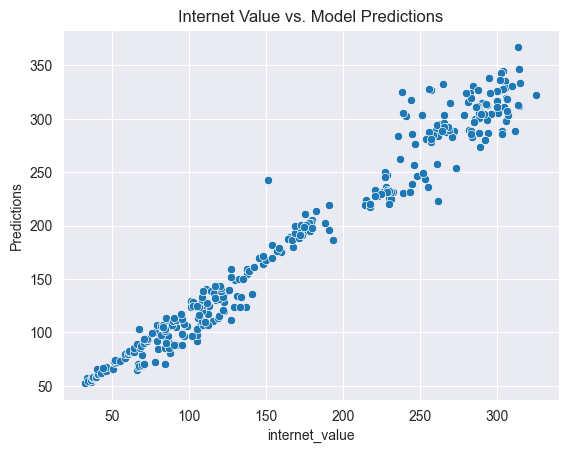

In [90]:
# Scatter plot of actual y values vs predicted values.
sns.scatterplot(x=y_test, y=y_pred_test)
plt.ylabel('Predictions')
plt.title('Internet Value vs. Model Predictions')

#### Residuals

In [91]:
# Train Residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

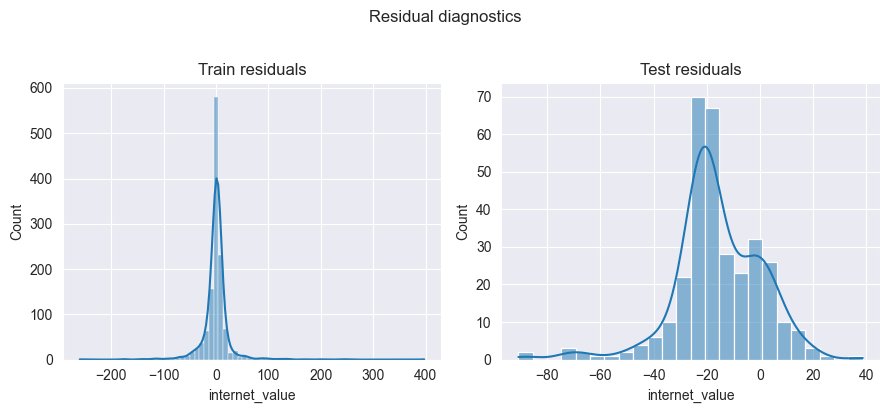

In [92]:
# Histplot (shows how errors are distributed)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
sns.histplot(residuals_train, ax=ax1, kde=True); ax1.set_title("Train residuals")
sns.histplot(residuals_test,  ax=ax2, kde=True); ax2.set_title("Test residuals")
fig.suptitle("Residual diagnostics", y=1.02)  # overall figure title
plt.tight_layout()

In [93]:
print('The mean training residual is essentially zero,',residuals_train.mean(), 'as expected for OLS with an intercept. Residuals are tightly clustered around 0 and roughly symmetric, indicating that the model fits the bulk of the data well and is not systematically over- or under-predicting. However, there are a small number of large residuals in the tails, corresponding to a few extreme observations (outliers).\n\nOn the test set, residuals are approximately bell-shaped but clearly shifted to the left, with a mean of about', round(residuals_test.mean(),2), '\nThis indicates that, on average, the model tends to overpredict internet retail sales in the test period by around', abs(round(residuals_test.mean())), 'units.\nThe left tail is somewhat heavier than the right, meaning that large overpredictions are more frequent than large underpredictions. This suggests a systematic bias in the test period, likely reflecting a change in behaviour of internet sales relative to the training period (e.g. structural shifts over time).\nCompared to the overall scale/variance of the target, this bias is [small/moderate], so the model is [reasonably / not fully] unbiased on unseen data.')
# TODO add scale/variance of the target, and find the bias

The mean training residual is essentially zero, -7.376162925658893e-14 as expected for OLS with an intercept. Residuals are tightly clustered around 0 and roughly symmetric, indicating that the model fits the bulk of the data well and is not systematically over- or under-predicting. However, there are a small number of large residuals in the tails, corresponding to a few extreme observations (outliers).

On the test set, residuals are approximately bell-shaped but clearly shifted to the left, with a mean of about -15.93 
This indicates that, on average, the model tends to overpredict internet retail sales in the test period by around 16 units.
The left tail is somewhat heavier than the right, meaning that large overpredictions are more frequent than large underpredictions. This suggests a systematic bias in the test period, likely reflecting a change in behaviour of internet sales relative to the training period (e.g. structural shifts over time).
Compared to the overall scale/variance

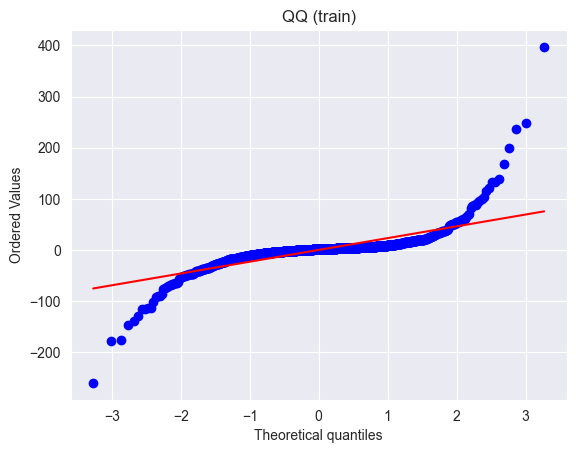

In [94]:
#QQ plot (QQ is stricter):
#Does my data look like it comes from a normal distribution?
stats.probplot(residuals_train, dist="norm", plot=plt); plt.title("QQ (train)"); plt.show()

In [95]:
# Does my data look like it comes from a normal distribution?
print('The QQ plot of the model residuals shows a noticeable S-shaped pattern: points follow the 45° line in the central region but deviate systematically in the lower and upper tails. In addition, a small number of points in the tails lie far from the reference line, indicating potential outliers.The S-shaped QQ pattern suggests that the residuals have heavier tails than a normal distribution (i.e. extreme positive and negative residuals occur more often than under a Gaussian assumption). The isolated points far from the line indicate influential outliers.\n')

print('Since classical OLS inference (t-tests, F-tests, confidence intervals) assumes normally distributed errors, the presence of heavy tails and outliers means that the reported p-values and confidence intervals may be somewhat optimistic (too narrow) and sensitive to these few extreme observations.\n')

print('Residual normality (QQ plot).For the OLS model of UK internet retail sales (2008–2025), the QQ plot of the residuals shows a clear S-shaped deviation from the 45° reference line, with points close to the line in the centre but bending away in both tails. This indicates that the residuals are not perfectly normally distributed and exhibit heavier tails than a Gaussian distribution. In practical terms, extremely high or low sales periods (for example, during exceptional events such as major economic shocks or the COVID-19 period) generate residuals that are larger in magnitude than would be expected under strict normality. A few points lie far from the line at the extremes, suggesting influential outliers.As a result, the classical OLS normality assumption is only approximately satisfied, and the reported t-tests, p-values and confidence intervals may be somewhat optimistic and sensitive to these extreme observations.\n')
# Easier explanation
print('When we look at the residuals (the differences between actual internet sales and what the model predicts), the QQ plot shows an S-shape with a few extreme points. This means that, while the model usually fits well, there are some months/years where internet retail sales are much higher or lower than the model expects – likely during unusual events such as sharp economic changes or the pandemic. These extreme periods behave like outliers and can make the statistical tests look slightly more confident than they really are, so we treat the detailed significance numbers with a bit of caution and focus more on the overall patterns and test-set performance.\n')

The QQ plot of the model residuals shows a noticeable S-shaped pattern: points follow the 45° line in the central region but deviate systematically in the lower and upper tails. In addition, a small number of points in the tails lie far from the reference line, indicating potential outliers.The S-shaped QQ pattern suggests that the residuals have heavier tails than a normal distribution (i.e. extreme positive and negative residuals occur more often than under a Gaussian assumption). The isolated points far from the line indicate influential outliers.

Since classical OLS inference (t-tests, F-tests, confidence intervals) assumes normally distributed errors, the presence of heavy tails and outliers means that the reported p-values and confidence intervals may be somewhat optimistic (too narrow) and sensitive to these few extreme observations.

Residual normality (QQ plot).For the OLS model of UK internet retail sales (2008–2025), the QQ plot of the residuals shows a clear S-shaped devia

#### Metrics

In [96]:
# Compare predictions to the corresponding true targets

# (y_train vs y_pred_train) for training diagnostics
mean_absolute_error_train = metrics.mean_absolute_error(y_train, y_pred_train)
mean_squared_error_train = np.mean((y_train - y_pred_train)**2)
root_mean_squared_error_train = np.sqrt(np.mean((y_train - y_pred_train)**2))
r2_train = metrics.r2_score(y_train, y_pred_train)

# (y_test vs y_pred_test) for generalization performance
mean_absolute_error_test = metrics.mean_absolute_error(y_test, y_pred_test)
mean_squared_error_test = metrics.mean_squared_error(y_test, y_pred_test)
root_mean_squared_error_test = np.sqrt(np.mean((y_test - y_pred_test)**2))
r2_test = metrics.r2_score(y_test, y_pred_test)

print("Training set:")
print("  y_train                             =", y_train.shape, "(true targets for training rows)")
print("  y_pred_train                        =", y_pred_train.shape, "(predicted targets for training rows)")
print("  MAE_train (Mean Absolute Error)     =", mean_absolute_error_train)
print("  MSE_train (Mean Squared Error)      =", mean_squared_error_train)
print("  RMSE_train (Root Mean Squared Error)=", root_mean_squared_error_train)
print("  R2_train                            =", r2_train)

print("\nTest set:")
print("  y_test                              =", y_test.shape, "(true targets for test rows)")
print("  y_pred_test                         =", y_pred_test.shape, "(predicted targets for test rows)")
print("  MAE_test (Mean Absolute Error)      =", mean_absolute_error_test)
print("  MSE_test (Mean Squared Error)       =", mean_squared_error_test)
print("  RMSE_test (Root Mean Squared Error) =", root_mean_squared_error_test)
print("  R2_test                             =", r2_test)

Training set:
  y_train                             = (1286,) (true targets for training rows)
  y_pred_train                        = (1286,) (predicted targets for training rows)
  MAE_train (Mean Absolute Error)     = 13.419140610237056
  MSE_train (Mean Squared Error)      = 868.4125698473783
  RMSE_train (Root Mean Squared Error)= 29.46884066004936
  R2_train                            = 0.9973750144675779

Test set:
  y_test                              = (322,) (true targets for test rows)
  y_pred_test                         = (322,) (predicted targets for test rows)
  MAE_test (Mean Absolute Error)      = 18.435653310273864
  MSE_test (Mean Squared Error)       = 530.7498382288657
  RMSE_test (Root Mean Squared Error) = 23.03800855605505
  R2_test                             = 0.9322550494905476


In [97]:
print('In average, we miss by this much in target units (millions):',mean_absolute_error_test)
print('MAE (test):',round(mean_absolute_error_test,3),'in millions')

In average, we miss by this much in target units (millions): 18.435653310273864
MAE (test): 18.436 in millions
